# Import Dependencies

In [ ]:
# Copyright 2024 Tiffani_Jackonia
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



In [33]:
import re
import random
import pandas as pd 
import numpy  as np
import matplotlib.pyplot as plt

In [34]:
INPUT_DIR = '../input/march-machine-learning-mania-2024/'
DATA_PATH = INPUT_DIR

In [36]:
mtourney_seeds = pd.read_csv(INPUT_DIR + 'MNCAATourneySeeds.csv')
mtourney_slots = pd.read_csv(INPUT_DIR + 'MNCAATourneySlots.csv')

# Historic seeds tourney

In [37]:
mtourney_slots['Rounds'] = mtourney_slots['Slot'].str[:2]

In [38]:
#tourney_seeds.query("CharlkRank == 1")
#mtourney_seeds
#mtourney_slots
#mtourney_slots.query('Season == 2023')

# Modeling & features 


In [39]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv'),
    pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv'),
], ignore_index=True)

df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [40]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + 'MRegularSeasonCompactResults.csv').assign(League='M'),
    pd.read_csv(DATA_PATH + 'WRegularSeasonCompactResults.csv').assign(League='W'),
], ignore_index=True)

df_season_results = df_season_results.drop(['NumOT', 'WLoc'], axis=1)

In [41]:
df_season_results['ScoreDiff'] = df_season_results['WScore'] - df_season_results['LScore']

In [42]:
df_season_results['WTeamName'] = df_season_results['WTeamID'].map(team_map)
df_season_results['LTeamName'] = df_season_results['LTeamID'].map(team_map)

<Axes: ylabel='Frequency'>

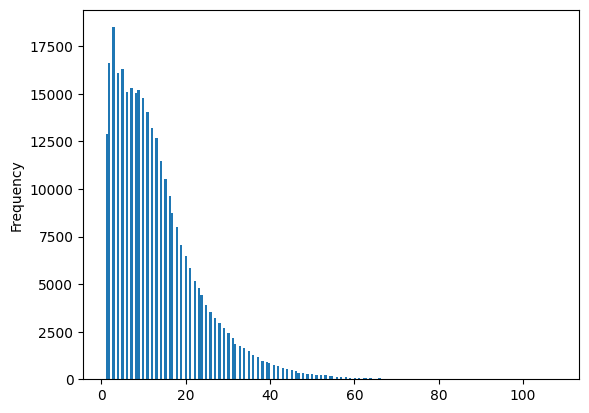

In [43]:
df_season_results.sort_values('ScoreDiff', ascending=False)['ScoreDiff'].plot(kind='hist', bins=200)

In [44]:
df_season_results['ScoreDiff'].value_counts().head(10)

ScoreDiff
3     18504
2     16643
5     16318
4     16102
7     15308
9     15181
6     15124
8     15044
10    14766
11    14055
Name: count, dtype: int64

In [45]:
df_season_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,League,ScoreDiff,WTeamName,LTeamName
0,1985,20,1228,81,1328,64,M,17,Illinois,Oklahoma
1,1985,25,1106,77,1354,70,M,7,Alabama St,S Carolina St
2,1985,25,1112,63,1223,56,M,7,Arizona,Houston Chr
3,1985,25,1165,70,1432,54,M,16,Cornell,Utica
4,1985,25,1192,86,1447,74,M,12,F Dickinson,Wagner
...,...,...,...,...,...,...,...,...,...,...
317442,2024,114,3409,76,3396,67,W,9,Tulsa,Temple
317443,2024,114,3424,63,3129,57,W,6,UNLV,Boise St
317444,2024,114,3433,69,3348,59,W,10,VCU,Rhode Island
317445,2024,114,3453,70,3236,61,W,9,WI Green Bay,PFW


In [46]:
num_win = df_season_results.groupby(['Season', 'WTeamID', 'League']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'League', 'DayNum']] \
    .rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

# each team's loss

num_loss = df_season_results.groupby(['Season', 'WTeamID', 'League']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'League', 'DayNum']] \
    .rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

team_season_win_loss = num_win.merge(num_loss, on=['Season','TeamID', "League"], how='outer')
team_season_win_loss['TeamName'] = team_season_win_loss['TeamID'].map(team_map)

In [47]:
#team_season_win_loss 

In [48]:
team_season_win_loss['NumLosses'] = team_season_win_loss['NumLosses'].fillna(0).astype('int')
team_season_win_loss['NumWins'] = team_season_win_loss['NumWins'].fillna(0).astype('int')

In [49]:
team_season_win_loss.loc[team_season_win_loss['NumLosses'] == 0].query('League == "M"') #.plot()

,Season,TeamID,League,NumWins,NumLosses,TeamName
282,1985,1102,M,5,0,Air Force
283,1985,1103,M,9,0,Akron
284,1985,1104,M,21,0,Alabama
285,1985,1106,M,10,0,Alabama St
286,1985,1108,M,19,0,Alcorn St
...,...,...,...,...,...,...
43841,2024,1474,M,10,0,Queens NC
43842,2024,1475,M,5,0,Southern Indiana
43843,2024,1476,M,3,0,Stonehill
43844,2024,1477,M,7,0,TX A&M Commerce


In [50]:
# how much points scored more in average

gap_win = df_season_results.groupby(['Season', 'WTeamID','League'])['ScoreDiff'].mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreDiff','League']].rename(columns={"ScoreDiff": "DiffWins", "WTeamID": "TeamID"})

# how much points scored less in average

gap_loss = df_season_results.groupby(['Season', 'LTeamID','League'])['ScoreDiff'].mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreDiff','League']].rename(columns={"ScoreDiff": "DiffLosses", "LTeamID": "TeamID"})

In [51]:
df_season_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,League,ScoreDiff,WTeamName,LTeamName
0,1985,20,1228,81,1328,64,M,17,Illinois,Oklahoma
1,1985,25,1106,77,1354,70,M,7,Alabama St,S Carolina St
2,1985,25,1112,63,1223,56,M,7,Arizona,Houston Chr
3,1985,25,1165,70,1432,54,M,16,Cornell,Utica
4,1985,25,1192,86,1447,74,M,12,F Dickinson,Wagner
...,...,...,...,...,...,...,...,...,...,...
317442,2024,114,3409,76,3396,67,W,9,Tulsa,Temple
317443,2024,114,3424,63,3129,57,W,6,UNLV,Boise St
317444,2024,114,3433,69,3348,59,W,10,VCU,Rhode Island
317445,2024,114,3453,70,3236,61,W,9,WI Green Bay,PFW


In [52]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID','League']).count().reset_index()[['Season', 'WTeamID','League']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID','League']).count().reset_index()[['Season', 'LTeamID','League']].rename(columns={"LTeamID": "TeamID"})
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID','League']).reset_index(drop=True)

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID','League'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID','League'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID','League'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID','League'], how='left')

df_features_season = df_features_season.fillna(0)

df_features_season[['NumWins', 'NumLosses']] = df_features_season[['NumWins', 'NumLosses']].astype('int')

In [53]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins']) + df_features_season['NumLosses']
df_features_season['ScoreDiffAvg'] = (
    (df_features_season['NumWins'] * df_features_season['DiffWins']) - 
    (df_features_season['NumLosses'] * df_features_season['DiffLosses']) /
    (df_features_season['NumWins'] * df_features_season['NumLosses'])
)

In [54]:
FEATURES = ['WinRatio', 'ScoreDiffAvg']

In [55]:
df_tourney_results = pd.concat([
    pd.read_csv(INPUT_DIR + 'WNCAATourneyCompactResults.csv'),
    pd.read_csv(INPUT_DIR + 'MNCAATourneyCompactResults.csv'),
], ignore_index=True)

df_tourney_results = df_tourney_results.drop(['NumOT', 'WLoc'], axis=1)

In [56]:
df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72
...,...,...,...,...,...,...
4029,2023,146,1274,88,1400,81
4030,2023,146,1361,57,1166,56
4031,2023,152,1163,72,1274,59
4032,2023,152,1361,72,1194,71


In [57]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2016,137,3107,61,3196,59
1,2016,137,3113,74,3308,52
2,2016,137,3120,68,3385,57
3,2016,137,3124,89,3225,59
4,2016,137,3177,97,3241,67


In [58]:
df = pd.merge(
    df,
    df_seeds,      #tourneySeeds (M+W) (season / seed / teamid)
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [59]:
df = pd.merge(
    df,
    df_seeds,      #tourneySeeds (M+W) (season / seed / teamid)
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [60]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [61]:
df['SeedW'] = df['SeedW']#.apply(treat_seed)
df['SeedL'] = df['SeedL']#.apply(treat_seed)

In [62]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumlossesW',
    'DiffWins': 'DiffWinsW',
    'DiffLosses': 'DiffLossesW',
    'WinRatio': 'WinRatioW',
    'ScoreDiffAvg': 'ScoreDiffAvgW',
}).drop(columns='TeamID', axis=1)

In [66]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumlossesL',
    'DiffWins': 'DiffWinsL',
    'DiffLosses': 'DiffLossesL',
    'WinRatio': 'WinRatioL',
    'ScoreDiffAvg': 'ScoreDiffAvgL',
}).drop(columns='TeamID', axis=1)

In [86]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA",
        "WScore": "ScoreA",
        "LTeamID": "TeamIdB",
        "LScore": "ScoreB",
     } 
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})

    lose_rename = {
        "WTeamID": "TeamIdB",
        "WScore" : "ScoreB",
        "LTeamID": "TeamIdA",
        "LScore": "ScoreA",
    }

    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})

    win_df = df.copy()
    lose_df = df.copy()

    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)

    return pd.concat([win_df, lose_df], axis=0, sort=False)


In [91]:
df = add_loosing_matches(df)

AttributeError: 'function' object has no attribute 'columns'

# Diff Between Teams Features

In [ ]:
cols_to_diff =[
    'Seed', 'WinRatio', ''
]